In [1]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
!pip install validators==0.20.0
import validators
import os.path
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
from sklearn import metrics


  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19570 sha256=34875947696644269ae36cdfd422b32da235c282626f8fbea17c3bd335922c18
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [2]:
# Load the Dataset
#data = pd.read_csv('../CSCT Masters Project/Datasets I Used/List of URLs.csv')
data = pd.read_csv('List of URLs.csv')
#data.head()
print(data.shape)
data.type.value_counts()

(651191, 2)


,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [3]:
#count of missing values in each column

missing = data.isnull().sum()
print(f"Number of missing values: {missing}")


before_duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {before_duplicates}")
df = data.drop_duplicates()
after_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows after removing duplicates: {after_duplicates}")


Number of missing values: url     0
type    0
dtype: int64
Number of duplicate rows: 10066
Number of duplicate rows after removing duplicates: 0


In [4]:
#value counts after removing duplicates
print(df.shape)
df.type.value_counts()

(641125, 2)


,count
type,
benign,428080
defacement,95308
phishing,94092
malware,23645


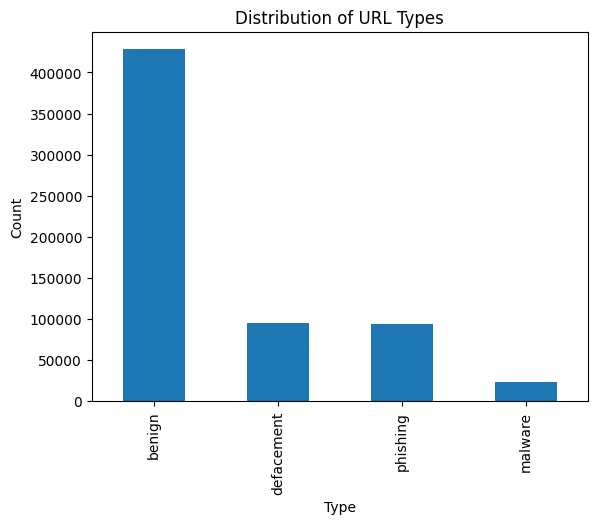

In [5]:
#plotting the value counts after removing the duplicates

import matplotlib.pyplot as plt
df['type'].value_counts().plot(kind='bar')
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Distribution of URL Types')
plt.show()

#print(df.head())

## URL Feature Extraction

In [6]:
#calculating the length of the URL and creating a new column/feature
df['length of url'] = df['url'].apply(lambda i: len(str(i)))

#checking whether the URL has an ip address
def having_ip_address(url):
  return 1 if validators.ip_address.ipv4(url) or validators.ip_address.ipv6(url) else 0
#creating a new column/feature
df['use of ip'] = df['url'].apply(lambda i: having_ip_address(i))
df.head()

<ipython-input-6-ad8f9da966d8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length of url'] = df['url'].apply(lambda i: len(str(i)))
<ipython-input-6-ad8f9da966d8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['use of ip'] = df['url'].apply(lambda i: having_ip_address(i))


,url,type,length of url,use of ip
0,br-icloud.com.br,phishing,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0


In [7]:
#checking whether the URL has hostname
def use_of_hostname(url):
    hostname = urlparse(url).hostname
    if hostname is None:  #handling the situation if the there is no hostname
        return 0
    return 1 if hostname in url else 0

#creating a new column/feature
df['use of hostname'] = df['url'].apply(use_of_hostname)

#calculating the length of hostname and creating a new column/feature
df['length of hostname'] = df['url'].apply(lambda i: len(urlparse(i).netloc))

df.head()

<ipython-input-7-6557b5b5030c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['use of hostname'] = df['url'].apply(use_of_hostname)
<ipython-input-7-6557b5b5030c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length of hostname'] = df['url'].apply(lambda i: len(urlparse(i).netloc))


,url,type,length of url,use of ip,use of hostname,length of hostname
0,br-icloud.com.br,phishing,16,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,23


In [29]:
#counting the number of directories in the URL
def count_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

#creating a new column/feature
df['count of /'] = df['url'].apply(lambda i: count_of_dir(i))

#counting the number of scheme separators "//" in the URL
def count_of_SchemeSeparator(url):
    urldir = urlparse(url).path
    return urldir.count('//')

#creating a new column/feature
df['count of //'] = df['url'].apply(lambda i: count_of_SchemeSeparator(i))

<ipython-input-29-063ea8444847>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of /'] = df['url'].apply(lambda i: count_of_dir(i))
<ipython-input-29-063ea8444847>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of //'] = df['url'].apply(lambda i: count_of_SchemeSeparator(i))


In [9]:
#calculating the length of first directory
def fd_length(url):
    parsed_url = urlparse(url)
    path_parts = parsed_url.path.split('/')
    if len(path_parts) > 1:
        return len(path_parts[1])
    else:
        return 0
#creating a new column/feature
df['length of first directory'] = df['url'].apply(fd_length)

#calculating the length of top level domain
def tld_length(url):
    parsed_url = urlparse(url)
    return len(parsed_url.netloc)

#creating a new column/feature
df['length of top level domain'] = df['url'].apply(tld_length)

df.head()

<ipython-input-9-7f2584ad75bd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length of first directory'] = df['url'].apply(fd_length)
<ipython-input-9-7f2584ad75bd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['length of top level domain'] = df['url'].apply(tld_length)


,url,type,length of url,use of ip,use of hostname,length of hostname,count of /,count of //,length of first directory,length of top level domain
0,br-icloud.com.br,phishing,16,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,2,0,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,3,0,7,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,21,1,0,9,21
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,23,1,0,9,23


In [10]:
#counting the number of subdomains in the URL
def count_of_subdomains(url):
  parsed_url = urlparse(url)
# Handling the case where hostname is None
  if parsed_url.hostname is None:
    return 0
  subdomains = parsed_url.hostname.split('.')
  return len(subdomains) - 2

#creating a new column/feature
df['count of subdomains'] = df['url'].apply(count_of_subdomains)

df.head()

<ipython-input-10-64a86a89dd15>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of subdomains'] = df['url'].apply(count_of_subdomains)


,url,type,length of url,use of ip,use of hostname,length of hostname,count of /,count of //,length of first directory,length of top level domain,count of subdomains
0,br-icloud.com.br,phishing,16,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,2,0,5,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,3,0,7,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,21,1,0,9,21,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,23,1,0,9,23,0


In [11]:
# checking whether a url shortening service has been used in the url or not

shorteners = [
    "bit.ly", "goo.gl", "shorte.st", "go2l.ink", "x.co", "ow.ly", "t.co",
    "tinyurl", "tr.im", "is.gd", "cli.gs", "yfrog.com", "migre.me",
    "ff.im", "tiny.cc", "url4.eu", "twit.ac", "su.pr", "twurl.nl",
    "snipurl.com", "short.to", "BudURL.com", "ping.fm", "post.ly",
    "Just.as", "bkite.com", "snipr.com", "fic.kr", "loopt.us",
    "doiop.com", "short.ie", "kl.am", "wp.me", "rubyurl.com", "om.ly",
    "to.ly", "bit.do", "t.co", "lnkd.in", "db.tt", "qr.ae", "adf.ly",
    "goo.gl", "bitly.com", "cur.lv", "tinyurl.com", "ow.ly", "bit.ly",
    "ity.im", "q.gs", "is.gd", "po.st", "bc.vc", "twitthis.com", "u.to",
    "j.mp", "buzurl.com", "cutt.us", "u.bb", "yourls.org", "x.co",
    "prettylinkpro.com", "scrnch.me", "filoops.info", "vzturl.com",
    "qr.net", "1url.com", "tweez.me", "v.gd", "tr.im", "link.zip.net"
]

def shortening_service(url):
    for shortener in shorteners:
        if shortener in url:
            return 1
    return 0

#creating a new column/feature
df['use of url shortner'] = df['url'].apply(lambda i: shortening_service(i))
df.head()

<ipython-input-11-4105bb3aecbb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['use of url shortner'] = df['url'].apply(lambda i: shortening_service(i))


,url,type,length of url,use of ip,use of hostname,length of hostname,count of /,count of //,length of first directory,length of top level domain,count of subdomains,use of url shortner
0,br-icloud.com.br,phishing,16,0,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,2,0,5,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,3,0,7,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,21,1,0,9,21,1,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,23,1,0,9,23,0,0


In [30]:
#counting the number of https and http in URL and creating a new column/feature

df['count of https'] = df['url'].apply(lambda i : i.count('https'))
df['count of http'] = df['url'].apply(lambda i : i.count('http'))

<ipython-input-30-d79d28f4ba1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of https'] = df['url'].apply(lambda i : i.count('https'))
<ipython-input-30-d79d28f4ba1e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of http'] = df['url'].apply(lambda i : i.count('http'))


In [13]:
#counting the number of multiple special characters and creating new column/feature
df['count of %'] = df['url'].apply(lambda i: i.count('%'))
df['count of ?'] = df['url'].apply(lambda i: i.count('?'))
df['count of -'] = df['url'].apply(lambda i: i.count('-'))
df['count of ='] = df['url'].apply(lambda i: i.count('='))
df['count of .'] = df['url'].apply(lambda i: i.count('.'))
df['count of www'] = df['url'].apply(lambda i: i.count('www'))
df['count of @'] = df['url'].apply(lambda i: i.count('@'))
df['count of #'] = df['url'].apply(lambda i: i.count('#'))
df['count of !'] = df['url'].apply(lambda i: i.count('!'))
df['count of $'] = df['url'].apply(lambda i: i.count('$'))
df['count of *'] = df['url'].apply(lambda i: i.count('*'))
df['count of _'] = df['url'].apply(lambda i: i.count('_'))

<ipython-input-13-276df6e90025>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of %'] = df['url'].apply(lambda i: i.count('%'))
<ipython-input-13-276df6e90025>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of ?'] = df['url'].apply(lambda i: i.count('?'))
<ipython-input-13-276df6e90025>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [14]:
#count the number of digits and letters in the URL and creating a new column/feature
df['count of numbers'] = df['url'].str.count('\d')

df['count of letters'] = df['url'].str.count('[a-zA-Z]')
df.head()

<ipython-input-14-fc888fe11e88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of numbers'] = df['url'].str.count('\d')
<ipython-input-14-fc888fe11e88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count of letters'] = df['url'].str.count('[a-zA-Z]')


,url,type,length of url,use of ip,use of hostname,length of hostname,count of /,count of //,length of first directory,length of top level domain,...,count of .,count of www,count of @,count of #,count of !,count of $,count of *,count of _,count of numbers,count of letters
0,br-icloud.com.br,phishing,16,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,0,2,0,5,0,...,2,0,0,0,0,0,0,1,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,0,3,0,7,0,...,2,0,0,0,0,0,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,0,1,21,1,0,9,21,...,3,1,0,0,0,0,0,2,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,0,1,23,1,0,9,23,...,2,0,0,0,0,0,0,1,22,199


In [15]:
#creating labels for each type of the URL
lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])

print(df["type_code"].value_counts())
#df.to_csv('my_data.csv', index=False)



type_code
0    428080
1     95308
3     94092
2     23645
Name: count, dtype: int64


<ipython-input-15-1510ce3a24e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["type_code"] = lb_make.fit_transform(df["type"])


In [31]:
#print the type code against its respective type name
for type_code, type_name in enumerate(lb_make.classes_):
    print(f"{type_code} = {type_name}")

0 = benign
1 = defacement
2 = malware
3 = phishing


## URL Feature Selection

                       Feature  Importance
17                count of www    0.136568
4                   count of /    0.125270
3           length of hostname    0.110054
7   length of top level domain    0.089469
6    length of first directory    0.070255
0                length of url    0.066737
25            count of letters    0.062689
11               count of http    0.055786
2              use of hostname    0.050666
8          count of subdomains    0.049126
16                  count of .    0.048121
24            count of numbers    0.041155
14                  count of -    0.024032
15                  count of =    0.020801
10              count of https    0.018847
13                  count of ?    0.010602
23                  count of _    0.009569
12                  count of %    0.005074
9          use of url shortner    0.003287
18                  count of @    0.000709
5                  count of //    0.000580
19                  count of #    0.000351
20         

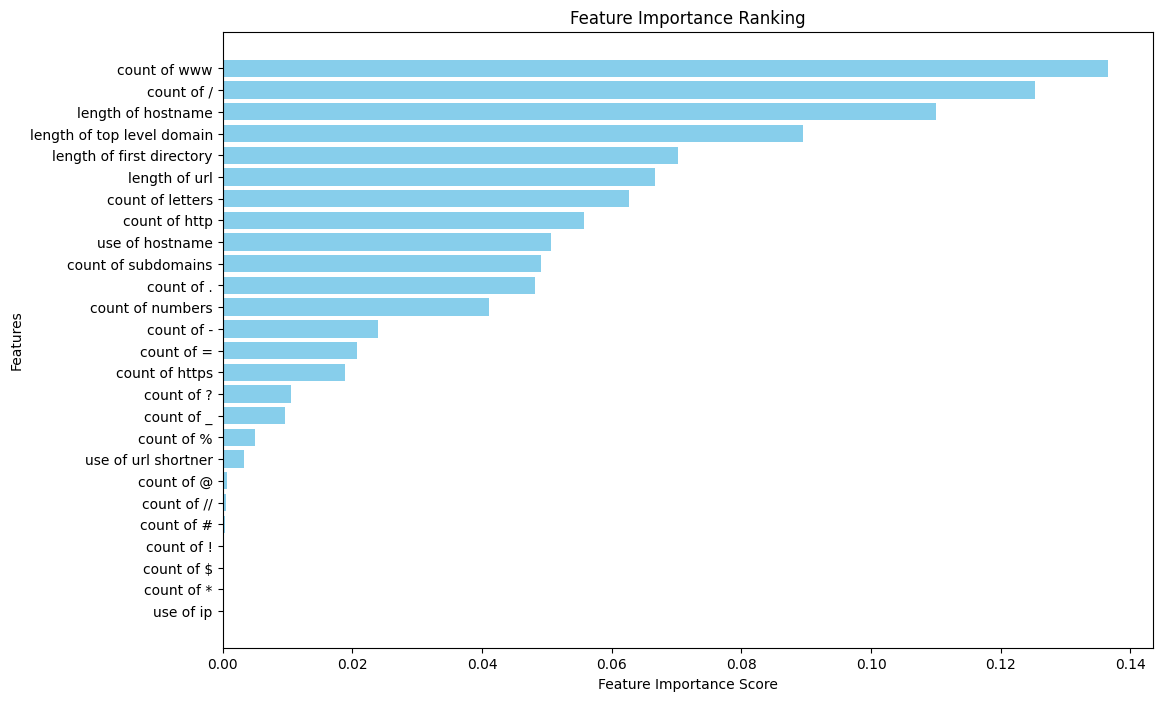

In [17]:
# Selecting only numeric columns for features
X = df.select_dtypes(include=['number']).drop(columns=['type_code'])  # Features
y = df['type_code']  # Target variable

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scaling the features (Random Forest does not require scaling, but it can be helpful for other models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# Getting feature importance scores
importances = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sorting by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the importance scores
print(importance_df)

# Plotting the feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

## The Model

In [18]:
top_10_features = importance_df.head(10)['Feature'].tolist() #columns with top 10 feature importance scoes

# Subsetting the training and test sets to only include the top 10 features
X_train_top_10 = X_train[top_10_features]
X_test_top_10 = X_test[top_10_features]

## Random Forest Classifier

In [19]:
# Retraining the Random Forest model on the top 10 features
model = RandomForestClassifier(random_state=42)
model.fit(X_train_top_10, y_train)

# Evaluating the model using cross-validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define the scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation
cv_results = cross_validate(model, X_train_top_10, y_train, cv=5, scoring=scoring)

# Output the cross-validation scores
print("Cross-Validation Accuracy Scores:", cv_results['test_accuracy'])
print("Average Accuracy:", cv_results['test_accuracy'].mean())
print("\nCross-Validation Precision Scores:", cv_results['test_precision'])
print("Average Precision:", cv_results['test_precision'].mean())
print("\nCross-Validation Recall Scores:", cv_results['test_recall'])
print("Average Recall:", cv_results['test_recall'].mean())
print("\nCross-Validation F1 Scores:", cv_results['test_f1'])
print("Average F1 Score:", cv_results['test_f1'].mean())

# Finally, evaluate the model on the test set
y_pred = model.predict(X_test_top_10)

# Compute precision, recall, and F1-score on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nFinal Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Cross-Validation Accuracy Scores: [0.95555664 0.9554689  0.95455254 0.95436732 0.95658023]
Average Accuracy: 0.9553051277052058

Cross-Validation Precision Scores: [0.95463067 0.95460944 0.95359193 0.9533461  0.95567006]
Average Precision: 0.9543696404963745

Cross-Validation Recall Scores: [0.95555664 0.9554689  0.95455254 0.95436732 0.95658023]
Average Recall: 0.9553051277052058

Cross-Validation F1 Scores: [0.95468482 0.95469729 0.9536399  0.95340239 0.95571091]
Average F1 Score: 0.9544270630968323

Final Model Performance on Test Set:
Accuracy: 0.9571
Precision: 0.9562
Recall: 0.9571
F1 Score: 0.9563


Confusion matrix, without normalization for random forest


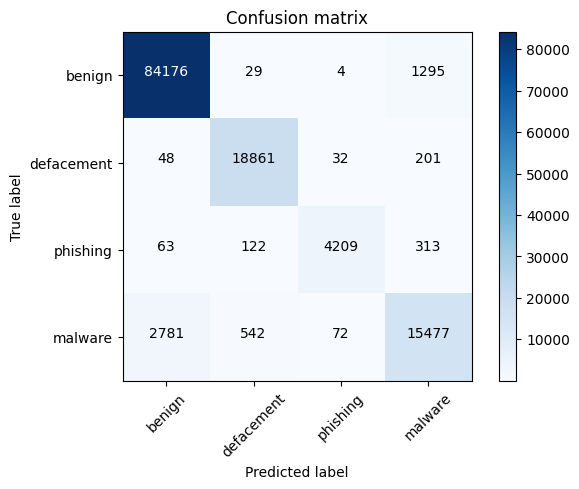

In [20]:
def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#Normalizing the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for random forest")
    else:
        print('Confusion matrix, without normalization for random forest')

    thresh = cm.max() / 2.

#Getting the actual TP,TN,FP,FN counts
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#confusion matrix using the test set
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])

#Ploting the confusion matrix
confusion_matrix(cm, classes=['benign', 'defacement', 'phishing', 'malware'])


## Multi-Layer Perceptron Classifier

In [21]:
scaler = StandardScaler()
X_train_top_10_scaled = scaler.fit_transform(X_train_top_10)
X_test_top_10_scaled = scaler.transform(X_test_top_10)

# Train an MLP Classifier on the top 10 features
mlp_model = MLPClassifier(max_iter=500, early_stopping=True, n_iter_no_change=10, random_state=42)  # Increase max_iter if the model does not converge
mlp_model.fit(X_train_top_10_scaled, y_train)

# Define the scoring metrics for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

# Perform cross-validation
cv_results = cross_validate(mlp_model, X_train_top_10_scaled, y_train, cv=5, scoring=scoring)

# Output the cross-validation scores
print("Cross-Validation Accuracy Scores:", cv_results['test_accuracy'])
print("Average Accuracy:", cv_results['test_accuracy'].mean())
print("\nCross-Validation Precision Scores:", cv_results['test_precision'])
print("Average Precision:", cv_results['test_precision'].mean())
print("\nCross-Validation Recall Scores:", cv_results['test_recall'])
print("Average Recall:", cv_results['test_recall'].mean())
print("\nCross-Validation F1 Scores:", cv_results['test_f1'])
print("Average F1 Score:", cv_results['test_f1'].mean())

# Finally, evaluate the MLP model on the test set
y_pred = mlp_model.predict(X_test_top_10_scaled)

# Compute accuracy, precision, recall, and F1-score on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nFinal MLP Classifier Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Cross-Validation Accuracy Scores: [0.94076818 0.93828232 0.93912069 0.9380386  0.93899396]
Average Accuracy: 0.939040748683954

Cross-Validation Precision Scores: [0.93926485 0.93648093 0.93749954 0.93656922 0.93733663]
Average Precision: 0.9374302332182332

Cross-Validation Recall Scores: [0.94076818 0.93828232 0.93912069 0.9380386  0.93899396]
Average Recall: 0.939040748683954

Cross-Validation F1 Scores: [0.93905173 0.93648668 0.93734591 0.93666165 0.93731181]
Average F1 Score: 0.9373715544691205

Final MLP Classifier Model Performance on Test Set:
Accuracy: 0.9369
Precision: 0.9351
Recall: 0.9369
F1 Score: 0.9353


Confusion matrix, without normalization for multi-layer perceptron


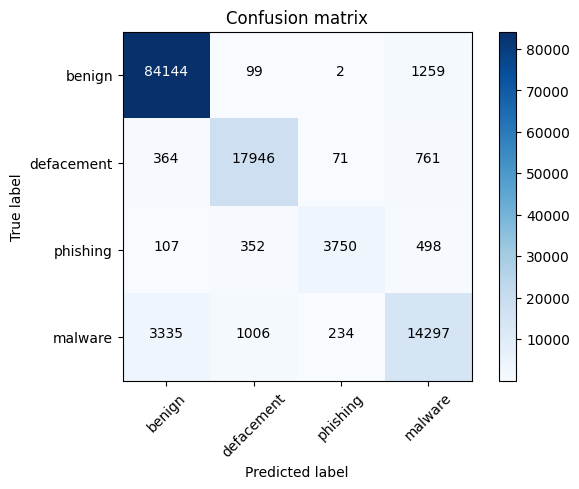

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#Normalizing the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for multi-layer perceptron")
    else:
        print('Confusion matrix, without normalization for multi-layer perceptron')

    thresh = cm.max() / 2.

#Getting the actual TP,TN,FP,FN counts
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Confusion matrix using the test set
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])

#Ploting the confusion matrix
plot_confusion_matrix(cm, classes=['benign', 'defacement', 'phishing', 'malware'])


## Naive Bayes Classifier

In [23]:
# Train a Naive Bayes model on the top 10 features
nb_model = GaussianNB()
nb_model.fit(X_train_top_10, y_train)

# Define the scoring metrics for cross-validation
scoring = {
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

# Perform cross-validation
cv_results = cross_validate(nb_model, X_train_top_10, y_train, cv=5, scoring=scoring)

# Output the cross-validation scores
print("Cross-Validation Accuracy Scores:", cv_results['test_accuracy'])
print("Average Accuracy:", cv_results['test_accuracy'].mean())
print("\nCross-Validation Precision Scores:", cv_results['test_precision'])
print("Average Precision:", cv_results['test_precision'].mean())
print("\nCross-Validation Recall Scores:", cv_results['test_recall'])
print("Average Recall:", cv_results['test_recall'].mean())
print("\nCross-Validation F1 Scores:", cv_results['test_f1'])
print("Average F1 Score:", cv_results['test_f1'].mean())

# Finally, evaluate the Naive Bayes model on the test set
y_pred = nb_model.predict(X_test_top_10)

# Compute accuracy, precision, recall, and F1-score on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nFinal Naive Bayes Model Performance on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Cross-Validation Accuracy Scores: [0.79636381 0.79668551 0.79639306 0.79508676 0.79756288]
Average Accuracy: 0.7964184051472022

Cross-Validation Precision Scores: [0.79854191 0.79670411 0.79901453 0.79764302 0.80047848]
Average Precision: 0.798476411298225

Cross-Validation Recall Scores: [0.79636381 0.79668551 0.79639306 0.79508676 0.79756288]
Average Recall: 0.7964184051472022

Cross-Validation F1 Scores: [0.77768933 0.77754148 0.777015   0.77608614 0.77819138]
Average F1 Score: 0.7773046683045087

Final Naive Bayes Model Performance on Test Set:
Accuracy: 0.7958
Precision: 0.7969
Recall: 0.7958
F1 Score: 0.7766


Confusion matrix, without normalization for naive bayes


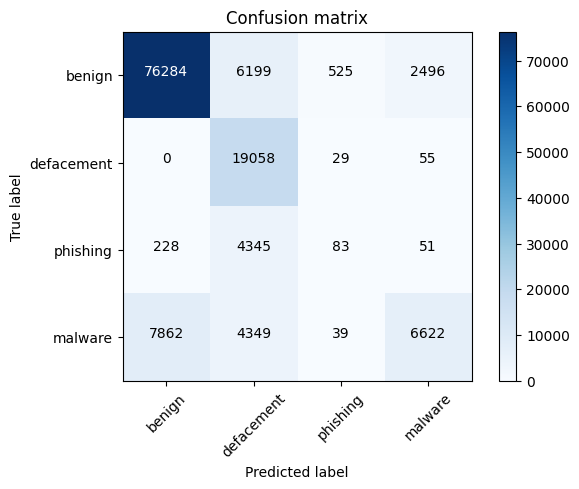

In [24]:
def confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

# Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix for naive bayes")
    else:
        print('Confusion matrix, without normalization for naive bayes')

    thresh = cm.max() / 2.

#Getting the actual TP,TN,FP,FN counts
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#confusion matrix using the test set
cm = metrics.confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])

#Ploting the confusion matrix
confusion_matrix(cm, classes=['benign', 'defacement', 'phishing', 'malware'])


## Real-Time Detection

In [25]:
#generating random URLs that depict a malicious URL

import random
import string

def random_url():
    domain = ''.join(random.choices(string.ascii_lowercase, k=8)) + ".com"
    path = ''.join(random.choices(string.ascii_lowercase + string.digits, k=10))
    return f"http://{domain}/{path}"

print(random_url())

http://gilxrude.com/vb74lp51gm


In [28]:
#new_url = random_url()
new_url = input("Enter a URL: ")

new_url_features = {
    'length of url': len(new_url),
    'use of ip': having_ip_address(new_url),
    'use of hostname': use_of_hostname(new_url),
    'length of hostname': len(urlparse(new_url).netloc),
    'count of /': count_of_dir(new_url),
    'count of //': count_of_SchemeSeparator(new_url),
    'length of first directory': fd_length(new_url),
    'length of top level domain': tld_length(new_url),
    'count of subdomains': count_of_subdomains(new_url),
    'use of url shortner': shortening_service(new_url),
    'count of https': new_url.count('https'),
    'count of http': new_url.count('http'),
    'count of %': new_url.count('%'),
    'count of ?': new_url.count('?'),
    'count of -': new_url.count('-'),
    'count of =': new_url.count('='),
    'count of .': new_url.count('.'),
    'count of www': new_url.count('www'),
    'count of @': new_url.count('@'),
    'count of #': new_url.count('#'),
    'count of !': new_url.count('!'),
    'count of $': new_url.count('$'),
    'count of *': new_url.count('*'),
    'count of _': new_url.count('_'),
    'count of numbers': new_url.count('\d'),
    'count of letters': new_url.count('[a-zA-Z]')
}

new_url_df = pd.DataFrame([new_url_features])

top_10_features = importance_df.head(10)['Feature'].tolist()
new_url_df_top10 = new_url_df[top_10_features]

#making prediction using Random Forest and Naive Bayes
prediction_rf = model.predict(new_url_df_top10)
prediction_nb = nb_model. predict(new_url_df_top10)

#scaling the features for MLPClassifier
scaler = StandardScaler()
scaler.fit(X_train_top_10)
new_url_df_top10_scaled = scaler.transform(new_url_df_top10)

#making prediction using MLPClassifier
prediction_mlp = mlp_model.predict(new_url_df_top10_scaled)

#printing the predictions
for prediction in prediction_rf:
    print(f"Random Forest Prediction: The given URL is {lb_make.inverse_transform([prediction])[0]} (Type code: {prediction})")

for prediction in prediction_nb:
    print(f"Naive Bayes Prediction: The given URL is {lb_make.inverse_transform([prediction])[0]} (Type code: {prediction})")

for prediction in prediction_mlp:
    print(f"Multi-Layer Perceptron Prediction: The given URL is {lb_make.inverse_transform([prediction])[0]} (Type code: {prediction})")

Enter a URL: https://courses.uwe.ac.uk/INB112/data-science
Random Forest Prediction: The given URL is malware (Type code: 2)
Naive Bayes Prediction: The given URL is defacement (Type code: 1)
Multi-Layer Perceptron Prediction: The given URL is malware (Type code: 2)
